In [1]:
import os
import sys
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import math
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import manhattan_distances

from tqdm.notebook import tqdm

np.set_printoptions(threshold=sys.maxsize)

(51, 98, 38, 90)
(51, 98, 38)
mouse 189924 voxels, 90 timepoints
mouse_mask2d shape = (189924, 1)
mouse_data2d shape = (189924, 90)


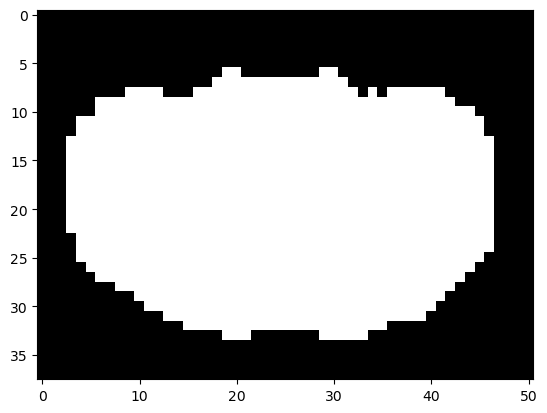

In [2]:
# Read in mouse data

# Read in data
mouse_data_img = nib.load('/home/fs0/ssf619/scratch/mouse_migp/mouse_RSN/mouse_migp_reoriented.nii.gz') # mouse migp 
mouse_data = mouse_data_img.get_fdata()
print(mouse_data.shape)

#  Mask brain to save computation
mouse_mask_img = nib.load('/home/fs0/ssf619/scratch/mouse_migp/mouse_RSN/func_brain_mask_reoriented.nii.gz') # mouse mask from migp
mouse_mask = mouse_mask_img.get_fdata()

# visualise a slice of mask to check 
print(mouse_mask.shape)
plt.imshow(mouse_mask[:,45,:].T,cmap='Greys_r')

mouse_nvoxels = np.prod(mouse_mask.shape)
mouse_ntimepoints = mouse_data.shape[3]

print(f'mouse {mouse_nvoxels} voxels, {mouse_ntimepoints} timepoints')

mouse_mask2d = (mouse_mask.reshape(mouse_nvoxels, 1) > 0)
mouse_data2d = mouse_data.reshape(mouse_nvoxels, mouse_ntimepoints)
print(f'mouse_mask2d shape = {mouse_mask2d.shape}')
print(f'mouse_data2d shape = {mouse_data2d.shape}')


In [3]:
# Specify coordinates 

coords = np.array([
    [26, 71, 18],
    [26, 72, 21],
    [26, 70, 22],
    [26, 68, 24],
    [26, 65, 25],
    [26, 62, 26],
    [26, 60, 28],
    [26, 58, 29],
    [26, 55, 30],
    [26, 52, 30],
    [29, 50, 31],
    [29, 48, 31]])

target_coords = np.array([
    [36, 48, 23], # ventral hippocampus
    [39, 55, 10], # basolateral amygdalar nucleus
    [28, 66, 9],  # nucleus accumbens
    [27, 59, 9],  # hypothalamus
    [32, 66, 18], # medial caudoputamen
    [27, 59, 30], # secondary motor area
    [33, 54, 31], # parietal association area
    [40, 66, 15], # dorsal agranular insula
    [32, 75, 18], # orbital area
    ])

target_coords_names = [
    "hipp", 
    "amyg",
    "NAcc", 
    "hypo", 
    "caud", 
    "SMA", 
    "SPL", 
    "ins", 
    "OFC"
    ]

print(f"{len(target_coords)} targets specified and {len(target_coords_names)} targets named")

2 targets specified and 2 targets named


In [4]:
# Calculate seed-target cosine similarity
mouse_maskdata2d = mouse_data2d[mouse_mask2d[:, 0] == 1, :] # only calculate masked voxels

mouse_seed_ts_list = [mouse_data[coord[0], coord[1], coord[2], :].reshape(1, mouse_ntimepoints) for coord in coords]
mouse_target_ts_list = [mouse_data[tcoord[0], tcoord[1], tcoord[2], :].reshape(1, mouse_ntimepoints) for tcoord in target_coords]

mouse_radar_datadict = {}

for coordi, seed_ts in enumerate(mouse_seed_ts_list):
    radar_sim = {}
    for tcoordi, target_ts in enumerate(mouse_target_ts_list):
        radar_cossim = cosine_similarity(seed_ts, target_ts)
        cossim = np.mean(radar_cossim)
        radar_sim[f"target_{tcoordi+1}"] = cossim

    mouse_radar_datadict[f"seed_{coordi+1}"] = radar_sim

mouse_df = pd.DataFrame.from_dict(mouse_radar_datadict)
mouse_df.index = target_coords_names

In [5]:
 mouse_df

,seed_1,seed_2,seed_3,seed_4,seed_5,seed_6,seed_7,seed_8,seed_9,seed_10,seed_11,seed_12
amyg,-0.028168,0.001194,0.001631,-0.018361,-0.070332,-0.050103,-0.022987,-0.047027,-0.071827,-0.087029,-0.099909,-0.071783
NAcc,0.067355,0.098869,0.087178,0.034499,0.020544,0.056957,0.059112,0.028926,-0.010778,-0.063394,0.056001,0.079653


In [6]:

# Normalisation function, columnwise (weakest target = 0, strongest target = 1)
def normalize_column(column):
    return (column - column.min()) / (column.max() - column.min())

In [7]:
# Normalise mouse dataframe columnwise

mouse_df_norm = mouse_df.copy()
mouse_seeds = [f'seed_{i}' for i in range(1, 13)]

for seed in tqdm(mouse_seeds, desc="normalising columns"):
    mouse_df_norm[seed] = normalize_column(mouse_df_norm[seed])

normalising columns:   0%|          | 0/12 [00:00<?, ?it/s]

In [8]:
mouse_df_norm

,seed_1,seed_2,seed_3,seed_4,seed_5,seed_6,seed_7,seed_8,seed_9,seed_10,seed_11,seed_12
amyg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NAcc,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Calculating fingerprints for human brain voxels

mask2d shape = (902629, 1)
data2d shape = (902629, 120)


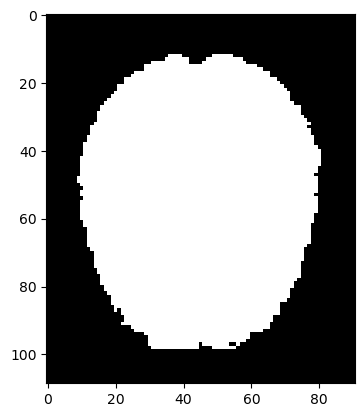

In [9]:
# Read in migp-ed data

# data_img = nib.load('/home/fs0/ssf619/scratch/fingerprinting_test/migp_120comps_100subj.nii.gz') # human migp, without smoothing
human_data_img = nib.load('/home/fs0/ssf619/scratch/fingerprinting_test/migp_120comps_100subj_5mm.nii.gz') # human migp, 5mm smoothed

human_data = human_data_img.get_fdata()
# plt.imshow(data[:,:,45,45].T,cmap='Greys_r') # view for human brain

human_mask_img = nib.load('/home/fs0/ssf619/scratch/fingerprinting_test/func_brain_mask.nii.gz') # human mask from migp
human_mask = human_mask_img.get_fdata()


plt.imshow(human_mask[:,:,45].T,cmap='Greys_r')

human_nvoxels = np.prod(human_mask.shape)
human_ntimepoints = human_data.shape[3]
# Reshape to 2d
human_mask2d = (human_mask.reshape(human_nvoxels, 1) > 0)
human_data2d = human_data.reshape(human_nvoxels, human_ntimepoints)
print(f'mask2d shape = {human_mask2d.shape}')
print(f'data2d shape = {human_data2d.shape}')

In [10]:
# Convert MNI152 coordinates to fsleyes voxel coordinates
def mni_to_fsl(coords):
    converted_coords = []
    for coord in coords:
        mni_x, mni_y, mni_z = coord
        fsleyes_x = math.trunc((-0.5*mni_x)+45)
        fsleyes_y = math.trunc((mni_y + 126)/2)
        fsleyes_z = math.trunc((mni_z + 72)/2)
        converted_coords.append([fsleyes_x, fsleyes_y, fsleyes_z])

    return converted_coords

# # Specify MNI coordinates (cingulate seeds from van Hout, 2024)

# coords = np.array([[4, 18, -10],
#                   [4, 30, -6],
#                   [4, 40, 0],
#                   [4, 38, 12],
#                   [4, 30, 22],
#                   [4, 16, 32],
#                   [4, 0, 38],
#                   [4, -14, 36],
#                   [4, -30, 38],
#                   [4, -40, 32],
#                   [4, -48, 16],
#                   [10, -46, 8]])
# print(f'{len(coords)} seeds specified')

target_coords = np.array([ 
    [26, -16, -20], # hippocampal formation
    [22, -6, -16], # amygdala
    [10, 16, -4], # nucleus accumbens
    [4, -6, -8], # hypothalamus
    [12, 16, 4], # caudate nucleus
    [8, -4, 60], # supplementary motor area
    [30, -56, 62], # superior parietal lobule
    [42, 12, -6], # anterior insula
    [6, 30, -20] # orbitofrontal cortex/area 14m
    ])

target_coords_names = [
    "hipp", 
    "amyg",
    "NAcc", 
    "hypo", 
    "caud", 
    "SMA", 
    "SPL", 
    "ins", 
    "OFC"
                      ]
                       
print(f'{len(target_coords)} target regions specified and {len(target_coords_names)} targets named')

coords = mni_to_fsl(coords)
target_coords = mni_to_fsl(target_coords)


2 target regions specified and 2 targets named


In [11]:
# Calculate human voxel fingerprints

column_names = [str(i) for i in range(human_data2d.shape[0])]
row_names = target_coords_names
human_df = pd.DataFrame(index=row_names, columns=column_names)
human_df[:] = np.NaN  # Fill the DataFrame with NaN

# Identify the indices where mouse_mask2d is True
true_indices = np.where(human_mask2d[:, 0] == 1)[0]
true_column_names = [str(i) for i in true_indices]

human_maskdata2d = human_data2d.copy()


for i in range(len(human_mask2d)):
    if human_mask2d[i, 0] != 1:
        human_maskdata2d[i, :] = np.NaN


valid_rows = ~np.isnan(human_maskdata2d).all(axis=1)
print(valid_rows.shape)


for tcoordi, tcoord in tqdm(enumerate(target_coords), total=len(target_coords)):  
    ts = human_data[tcoord[0], tcoord[1], tcoord[2], :].reshape(human_ntimepoints, 1)

    # for rowi, row in tqdm(enumerate(valid_rows), desc="Valid Rows", total = len(valid_rows), leave = True):
    valid_human_maskdata2d = human_maskdata2d[valid_rows]

    if valid_human_maskdata2d.size > 0:
        # Calculate cosine similarity between time series of my coordinate and rest of brain (as specified by the mask)
        cossim = cosine_similarity(ts.T, valid_human_maskdata2d)

    # # save the results in a volume
    # results2d = np.zeros(mouse_mask2d.shape)
    # results2d[mouse_mask2d[:, 0]] = cossim.T
    # results_coordi = np.zeros(mouse_mask.shape)
    # results_coordi[:, :, :] = results2d.reshape(mouse_mask.shape)

    # # Save the results for each target
    # results_img = nib.Nifti1Image(results_coordi, mouse_mask_img.affine, mouse_mask_img.header)
    # # nib.save(results_img, f'mouse_cossim_target{tcoordi}.nii.gz')

    # append cossim values to mouse dataframe only if that voxel is "True" in the maskdata2d
    row_name = target_coords_names[tcoordi]
    row_df = pd.DataFrame(cossim, columns=true_column_names, index=[row_name])
    human_df.update(row_df) 

(902629,)


  0%|          | 0/2 [00:00<?, ?it/s]

In [12]:
human_df

,0,1,2,3,4,5,6,7,8,9,...,902619,902620,902621,902622,902623,902624,902625,902626,902627,902628
amyg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NAcc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
non_nan_columns = human_df.notna().any()
# print(non_nan_columns[non_nan_columns].index.tolist())

In [14]:
human_df.iloc[:,152542:153560]

,152542,152543,152544,152545,152546,152547,152548,152549,152550,152551,...,153550,153551,153552,153553,153554,153555,153556,153557,153558,153559
amyg,0.073838,0.091679,0.108897,0.100483,0.084544,0.07832,0.080565,0.086635,0.090915,0.086012,...,0.118902,0.156906,0.184074,0.203901,0.227996,0.227347,0.165172,0.122354,0.11082,0.089892
NAcc,0.05067,0.064644,0.087529,0.104107,0.105563,0.093561,0.069265,0.042251,0.032973,0.045896,...,0.096113,0.097489,0.104335,0.109874,0.108508,0.103598,0.107869,0.099271,0.103902,0.117576


In [15]:
# Normalise human voxel fingerprints

human_df_norm = human_df.copy()

tqdm.pandas(desc="Normalizing Columns")
human_df_norm = human_df.progress_apply(lambda x: normalize_column(x))

human_df_norm.iloc[:,152542:153560]


Normalizing Columns:   0%|          | 0/902629 [00:00<?, ?it/s]

,152542,152543,152544,152545,152546,152547,152548,152549,152550,152551,...,153550,153551,153552,153553,153554,153555,153556,153557,153558,153559
amyg,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
NAcc,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Mouse Columns:   0%|          | 0/12 [00:00<?, ?it/s]

Human Columns:   0%|          | 0/902629 [00:00<?, ?it/s]

0.1789993452459427


Human Columns:   0%|          | 0/902629 [00:00<?, ?it/s]

0.1789993452459427


Human Columns:   0%|          | 0/902629 [00:00<?, ?it/s]

0.1789993452459427


Human Columns:   0%|          | 0/902629 [00:00<?, ?it/s]

0.1789993452459427


Human Columns:   0%|          | 0/902629 [00:00<?, ?it/s]

0.1789993452459427


Human Columns:   0%|          | 0/902629 [00:00<?, ?it/s]

0.1789993452459427


Human Columns:   0%|          | 0/902629 [00:00<?, ?it/s]

0.1789993452459427


Human Columns:   0%|          | 0/902629 [00:00<?, ?it/s]

0.1789993452459427


Human Columns:   0%|          | 0/902629 [00:00<?, ?it/s]

0.1789993452459427


Human Columns:   0%|          | 0/902629 [00:00<?, ?it/s]

0.1789993452459427


Human Columns:   0%|          | 0/902629 [00:00<?, ?it/s]

0.1789993452459427


Human Columns:   0%|          | 0/902629 [00:00<?, ?it/s]

0.1789993452459427


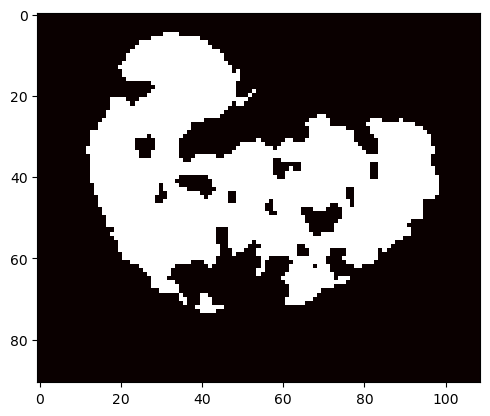

In [16]:
# Match human voxel fingerprints to mouse seed fingerprints

from tqdm.notebook import tqdm

for columni, column in tqdm(enumerate(mouse_df_norm.columns), desc="Mouse Columns", total=len(mouse_df_norm.columns)):
    mouse_fingerprint = mouse_df_norm[column].values.reshape(1,-1)
    
    fingerprint_results2d = np.zeros(human_mask2d.shape)
    fingerprint_results_coordi = np.zeros(human_mask.shape)

    true_indices = np.where(human_mask2d[:, 0])[0]  

    for voxeli, voxel in tqdm(enumerate(human_df_norm.columns), desc="Human Columns", total=len(human_df_norm.columns), leave=True):
    
        human_voxel_fingerprint = human_df_norm[voxel].values.astype(float).reshape(1, -1)  # Convert to float

        if not np.isnan(human_voxel_fingerprint).all():
            fcossim = cosine_similarity(mouse_fingerprint, human_voxel_fingerprint)[0][0]
            fingerprint_results2d[voxeli] = fcossim
        
    fingerprint_results_coordi[:, :, :] = fingerprint_results2d.reshape(human_mask.shape)

    print(np.mean(fingerprint_results_coordi))

    # Save the results for each seed
    fingerprint_results_img = nib.Nifti1Image(fingerprint_results_coordi, human_mask_img.affine, human_mask_img.header)
    # nib.save(fingerprint_results_img, f'mouse2human_2targA_seed{columni+1}.nii.gz')
    

    plt.imshow(fingerprint_results_coordi[30,:,:].T,cmap='hot')